In [6]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.sans-serif'] = ['STFangsong']  # 图中显示中文
plt.rcParams['axes.unicode_minus'] = False  # 图中正常显示负号

def create_matrix(n):
    dim = (n-1) ** 2
    A = np.zeros((dim, dim))
    
    #每个分块矩阵的维数
    block_size = n-1
    
    # A对角元为T_(n-1)
    for i in range(block_size):
        start_idx = i * block_size
        # 主对角线为4
        for j in range(block_size):
            A[start_idx + j, start_idx + j] = 4
        # 次对角线为1
        for j in range(block_size - 1):
            A[start_idx + j, start_idx + j + 1] = 1
            A[start_idx + j + 1, start_idx + j] = 1
    
    # A次对角线 -I_(n-1)
    for i in range(block_size - 1):
        start_idx = i * block_size
        next_idx = (i + 1) * block_size

        for j in range(block_size):
            A[start_idx + j, next_idx + j] = -1
            A[next_idx + j, start_idx + j] = -1
    
    return A

def create_b(n):
    dim = (n-1) ** 2
    e = np.ones(dim)
    A = create_matrix(n)
    return A @ e

def jacobi(A, b, tol=1e-8, max_iter=1000):

    n = len(A)
    x = np.zeros(n)
    D = np.diag(A)
    R = A - np.diagflat(D)
    
    errors = []
    
    for i in range(max_iter):
        x_new = (b - R @ x) / D
        error = np.linalg.norm(b - A @ x_new)
        errors.append(error)
        
        if error < tol:
            return x_new, errors, i+1
        x = x_new
        
    return x, errors, max_iter


def gauss_seidel(A, b,tol=1e-8, max_iter=1000):

    n = len(A)
    x = np.zeros(n)
    errors = []

    for iter_count in range(max_iter):
        x_new = x.copy()

        for i in range(n):
            s1 = np.dot(A[i, :i], x_new[:i])
            s2 = np.dot(A[i, i + 1:], x[i + 1:])
            x_new[i] = (b[i] - s1 - s2) / A[i, i]

        error = np.linalg.norm(b - A @ x_new)
        errors.append(error)

        if error < tol:
            return x_new, errors, iter_count + 1

        x = x_new

    return x, errors, max_iter

def sor(A, b, omega, tol=1e-8, max_iter=1000):

    n = len(A)
    x = np.zeros(n)
    errors = []
    
    for iter_count in range(max_iter):
        x_new = x.copy()
        
        for i in range(n):
            s1 = np.dot(A[i, :i], x_new[:i])
            s2 = np.dot(A[i, i + 1:], x[i + 1:])
            x_new[i] = (1 - omega) * x[i] + (omega * (b[i] - s1 - s2)) / A[i, i]
        
        error = np.linalg.norm(b - A @ x_new)
        errors.append(error)
        
        if error < tol:
            return x_new, errors, iter_count + 1
            
        x = x_new
        
    return x, errors, max_iter


Text(0.5, 1.0, '不同迭代方法的每步迭代误差比较')

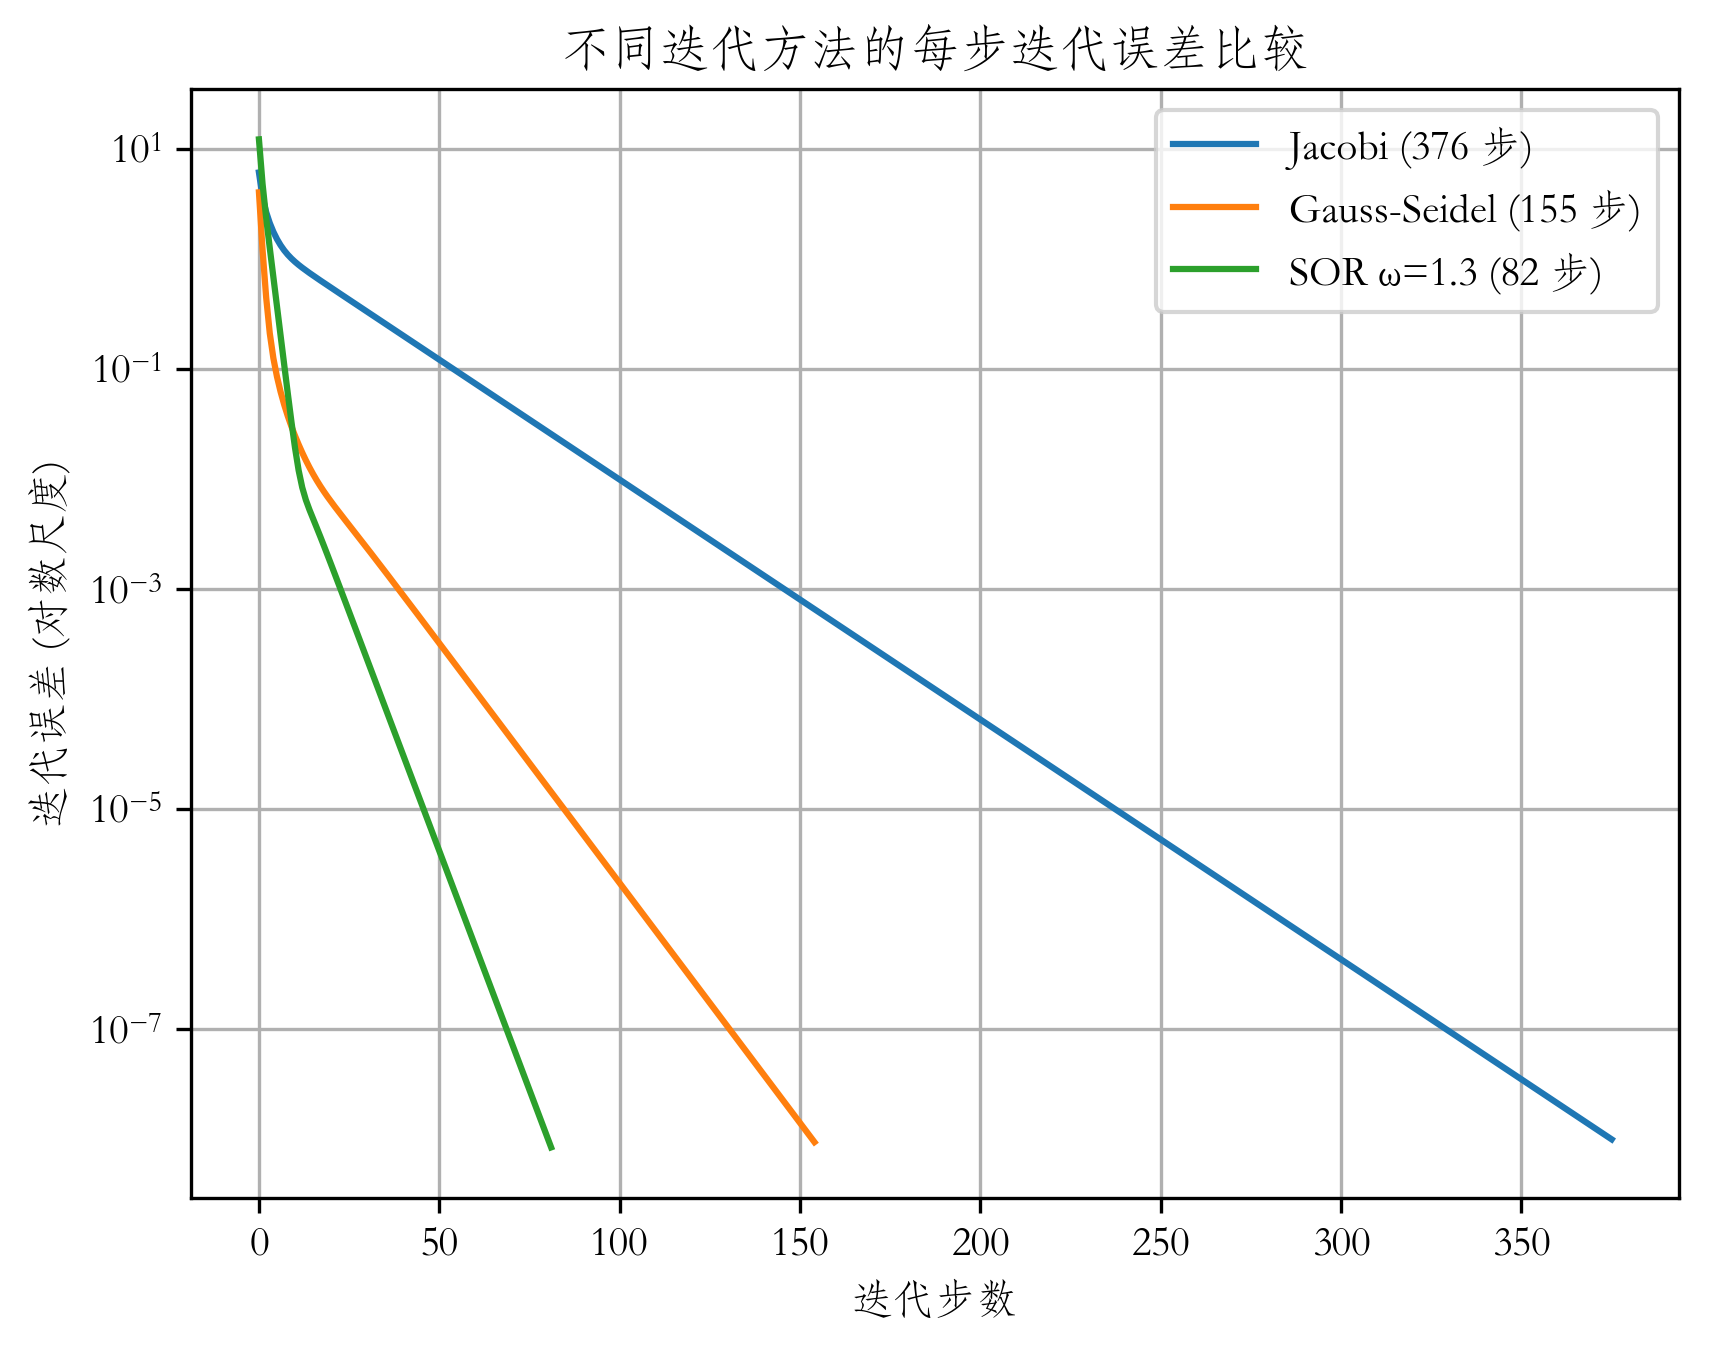

In [7]:
n = 10  # 矩阵维数 + 1
A = create_matrix(n)
b = create_b(n)
omega = 1.3  


_, jacobi_errors, jacobi_steps = jacobi(A, b)
_, gs_errors, gs_steps = gauss_seidel(A, b)
_, sor_errors, sor_steps = sor(A, b, omega)

# 画图
plt.figure()
plt.semilogy(jacobi_errors, label=f'Jacobi ({jacobi_steps} 步)')
plt.semilogy(gs_errors, label=f'Gauss-Seidel ({gs_steps} 步)')
plt.semilogy(sor_errors, label=f'SOR ω=1.3 ({sor_steps} 步)')
plt.grid(True)
plt.xlabel('迭代步数')
plt.ylabel('迭代误差 (对数尺度)')
plt.legend()
plt.title('不同迭代方法的每步迭代误差比较')

In [8]:

# 画表 3.1
n = 4  #  9x9 矩阵
A = create_matrix(n)
b = create_b(n)
omegas = [0.2, 0.4, 0.6, 0.8, 1.0]

print("\nTable 3.1:不同松弛因子的收敛速度比较")
print(f"{'ω':<10} {'Steps':<10}{'n      '} {'ρ(G)':<10}{'Error':<15} ")
print("-" * 45)

for omega in omegas:
    _, errors, steps = sor(A, b, omega)

    D = np.diag(np.diag(A))
    L = np.tril(A, -1)
    U = np.triu(A, 1)
    G = np.linalg.inv(D/omega + L) @ ((1-omega)/omega * D - U)
    rho = np.max(np.abs(np.linalg.eigvals(G)))
    
    print(f"{omega:<10.1f} {steps:<10d}{'4      '} {rho:<10.4f} {errors[-1]:<15.2e} ")


Table 3.1:不同松弛因子的收敛速度比较
ω          Steps     n       ρ(G)      Error           
---------------------------------------------
0.2        275       4       0.9369     9.68e-09        
0.4        122       4       0.8627     9.25e-09        
0.6        71        4       0.7730     7.90e-09        
0.8        44        4       0.6593     9.55e-09        
1.0        28        4       0.5000     5.93e-09        


In [19]:
import numpy as np
import time
from pyamg.relaxation.relaxation import jacobi, gauss_seidel, sor
from scipy.io import mmread
from scipy.sparse import eye, diags

def read_mtx_file(file_path):
    # Read the sparse matrix
    sparse_matrix = mmread(file_path)
    
    # Normalize the matrix (keeping it sparse)
    row_sums = sparse_matrix.sum(axis=1).A.flatten()
    row_sums[row_sums == 0] = 1
    row_diag = diags(1.0 / row_sums)
    return row_diag @ sparse_matrix

def measure_method(method, M, b, x0, tol=1e-8, max_iter=1000, **kwargs):
    x = x0.copy()
    start_time = time.time()
    residual = float('inf')
    
    for i in range(max_iter):
        method(M, x, b, **kwargs)
        # Calculate residual using sparse matrix multiplication
        residual = np.linalg.norm(M @ x - b)
        if residual < tol:
            break
    end_time = time.time()
    
    return {
        "iterations": i + 1,
        "time": end_time - start_time,
        "residual": residual,
    }

# Define matrix files to process
matrix_files = {
    'wiki-Vote': 'wiki-Vote.mtx',
    'web-Google': 'web-Google.mtx',
    'web-Stanford': 'web-Stanford.mtx'
}

# Process each matrix file
for name, file_name in matrix_files.items():
    print(f"\nProcessing matrix: {name} ({file_name})")
    A = read_mtx_file(file_name)
    print(f"Matrix dimensions: {A.shape}")

    alpha = 0.85
    n = A.shape[0]
    I = eye(n, format='csr')  
    b = np.ones(n) / n
    M = I - alpha * A  

    x0 = np.zeros(n)
    tol = 1e-8
    max_iter = 1000

    # Jacobi method
    jacobi_result = measure_method(jacobi, M, b, x0, tol=tol, max_iter=max_iter)
    print("\nJacobi method:")
    print(f"  Iterations: {jacobi_result['iterations']}")
    print(f"  Runtime: {jacobi_result['time']:.4f} seconds")
    print(f"  Final residual: {jacobi_result['residual']:.4e}")

    # Gauss-Seidel method
    gs_result = measure_method(gauss_seidel, M, b, x0, tol=tol, max_iter=max_iter, sweep='forward')
    print("\nGauss-Seidel method:")
    print(f"  Iterations: {gs_result['iterations']}")
    print(f"  Runtime: {gs_result['time']:.4f} seconds")
    print(f"  Final residual: {gs_result['residual']:.4e}")

    # SOR method
    omega = 1.1
    sor_result = measure_method(sor, M, b, x0, tol=tol, max_iter=max_iter, omega=omega, sweep='forward')
    print("\nSOR method:")
    print(f"  Iterations: {sor_result['iterations']}")
    print(f"  Runtime: {sor_result['time']:.4f} seconds")
    print(f"  Final residual: {sor_result['residual']:.4e}")


Processing matrix: wiki-Vote (wiki-Vote.mtx)
Matrix dimensions: (8297, 8297)

Jacobi method:
  Iterations: 28
  Runtime: 0.0114 seconds
  Final residual: 9.7343e-09

Gauss-Seidel method:
  Iterations: 16
  Runtime: 0.0055 seconds
  Final residual: 9.7127e-09

SOR method:
  Iterations: 14
  Runtime: 0.0045 seconds
  Final residual: 6.0260e-09

Processing matrix: web-Google (web-Google.mtx)
Matrix dimensions: (916428, 916428)

Jacobi method:
  Iterations: 64
  Runtime: 6.0617 seconds
  Final residual: 9.7653e-09

Gauss-Seidel method:
  Iterations: 36
  Runtime: 2.9300 seconds
  Final residual: 7.8500e-09

SOR method:
  Iterations: 124
  Runtime: 11.0099 seconds
  Final residual: 9.6462e-09

Processing matrix: web-Stanford (web-Stanford.mtx)
Matrix dimensions: (281903, 281903)

Jacobi method:
  Iterations: 75
  Runtime: 1.7853 seconds
  Final residual: 9.4220e-09

Gauss-Seidel method:
  Iterations: 40
  Runtime: 0.8755 seconds
  Final residual: 8.5585e-09

SOR method:
  Iterations: 153
 


处理矩阵: Wiki投票
矩阵维度: (8297, 8297)


SOR方法计算中:   1%|▏         | 13/1000 [00:00<00:00, 2162.18it/s]


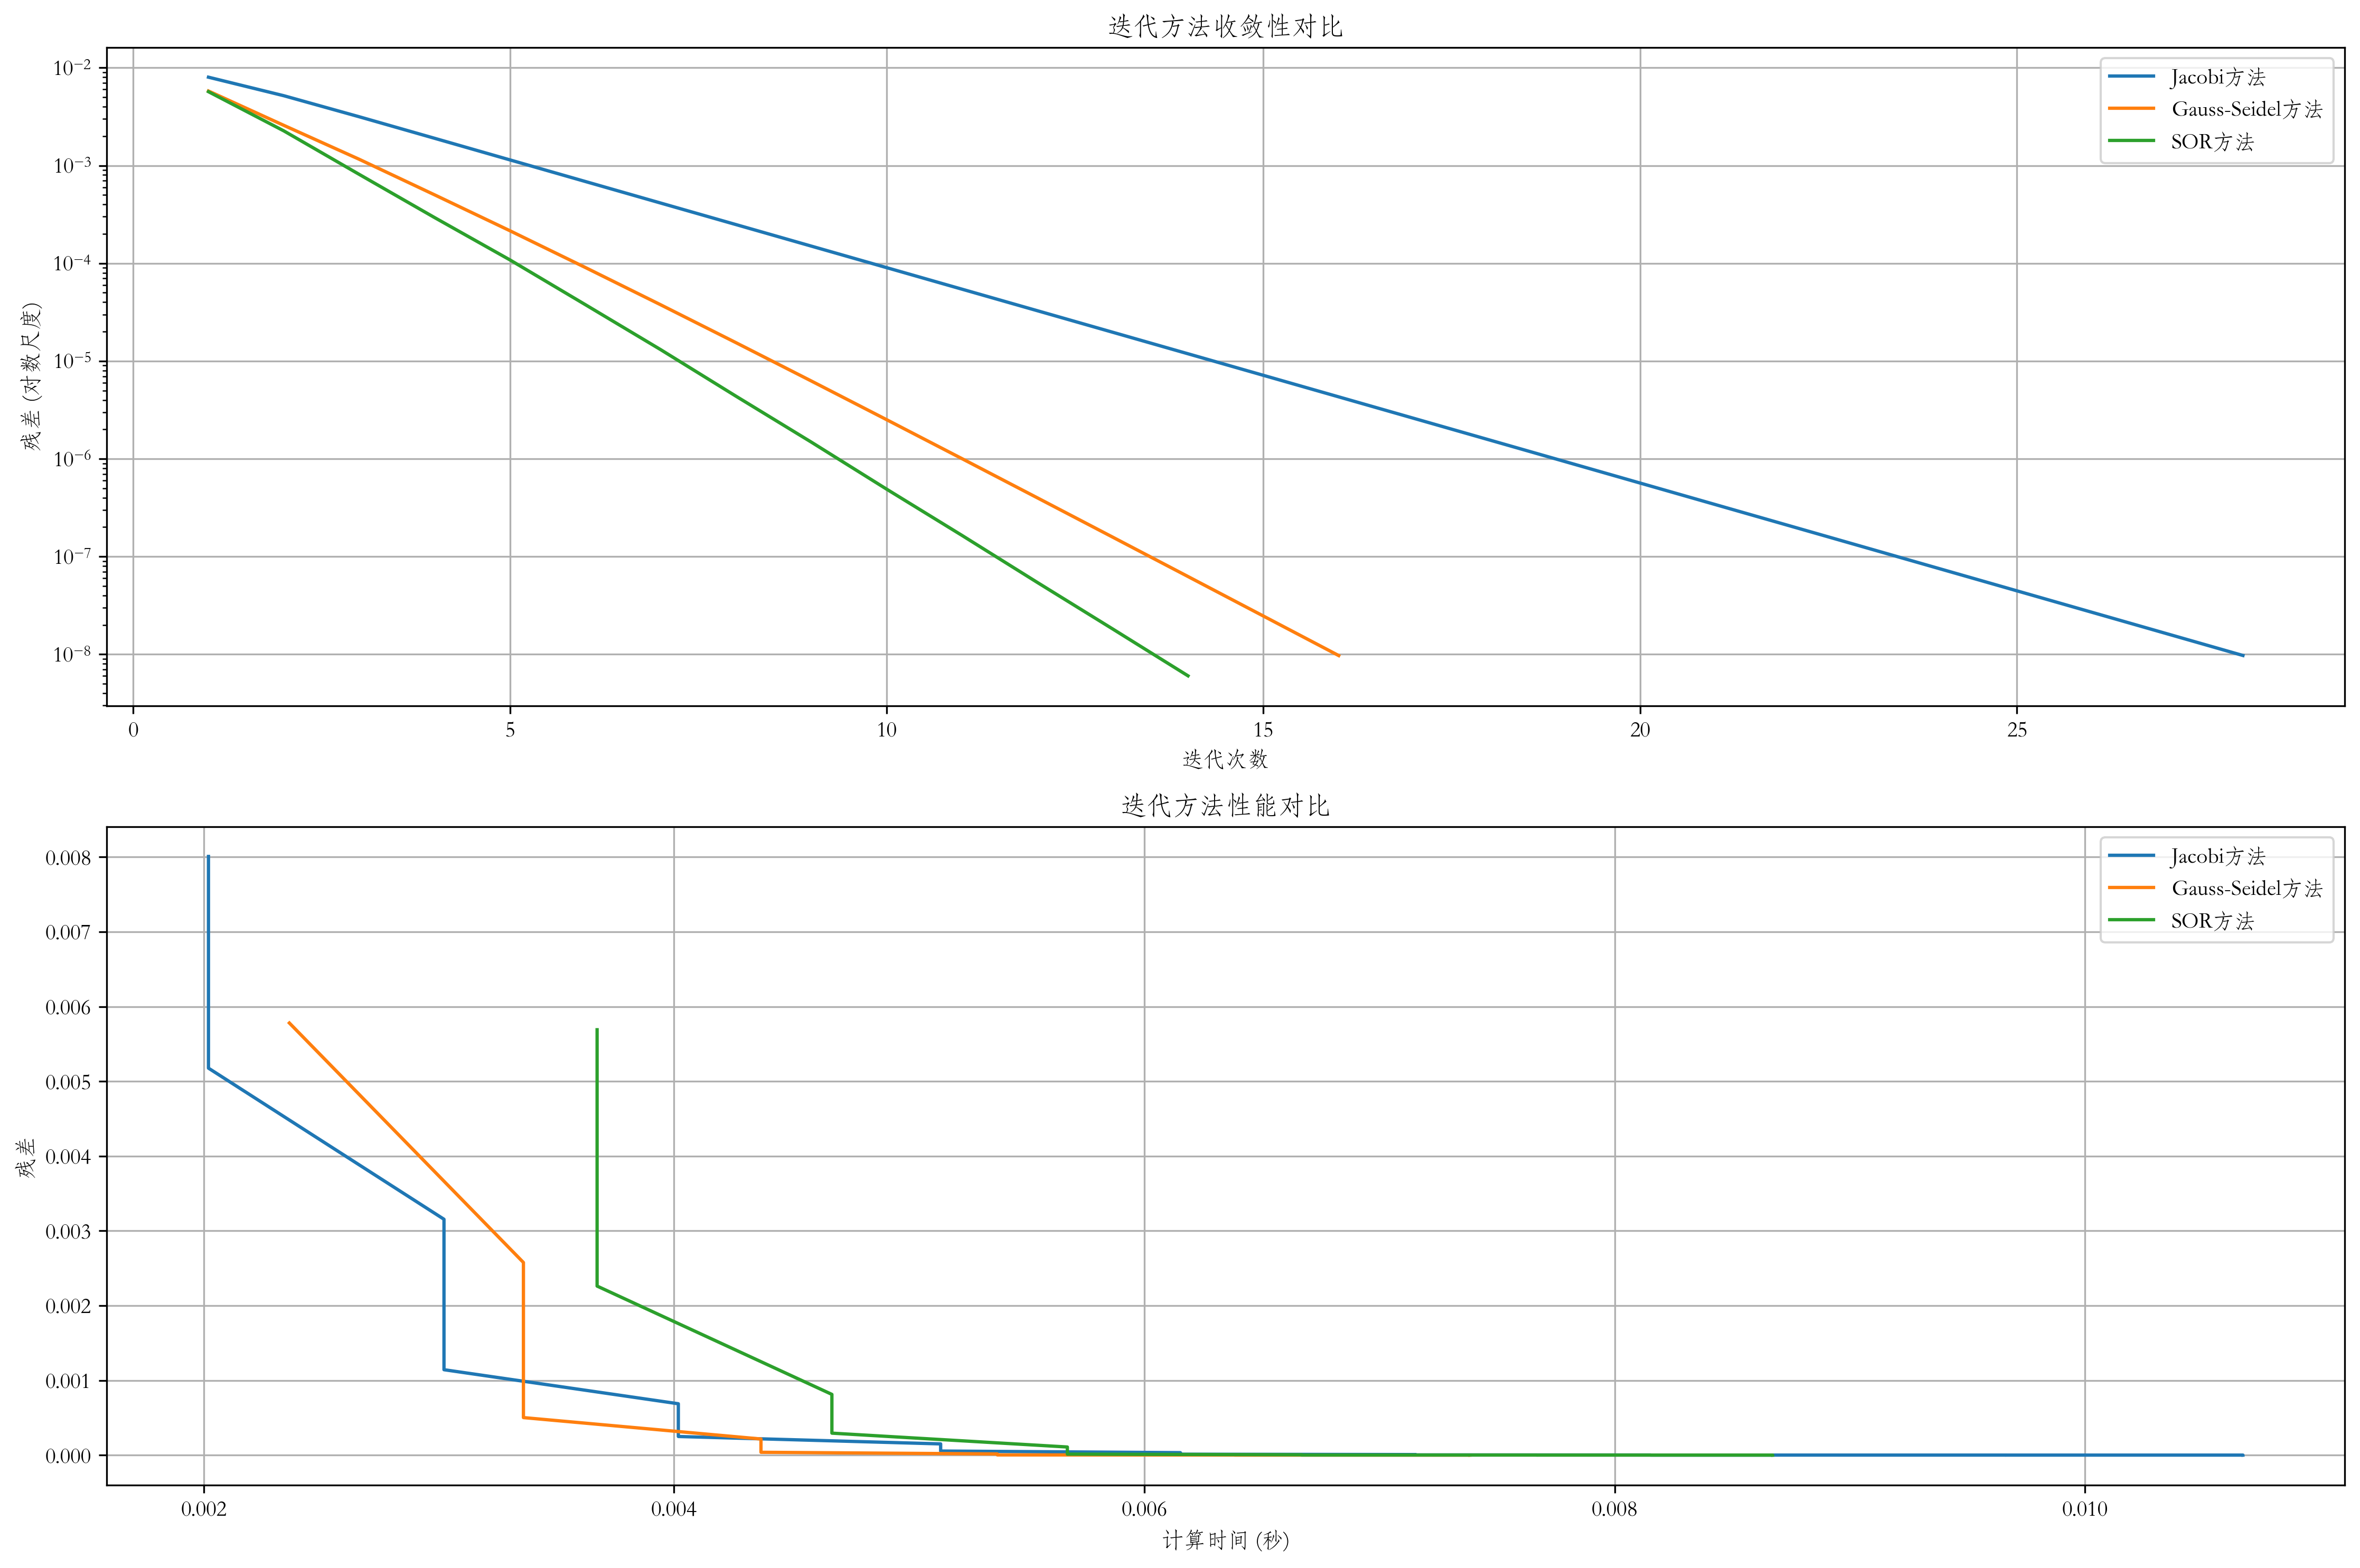


Jacobi方法:
  迭代次数: 28
  计算时间: 0.0107 秒
  最终残差: 9.7343e-09

Gauss-Seidel方法:
  迭代次数: 16
  计算时间: 0.0074 秒
  最终残差: 9.7127e-09

SOR方法:
  迭代次数: 14
  计算时间: 0.0087 秒
  最终残差: 6.0260e-09

处理矩阵: Google网页
矩阵维度: (916428, 916428)


SOR方法计算中:  12%|█▏        | 123/1000 [00:11<01:22, 10.59it/s]


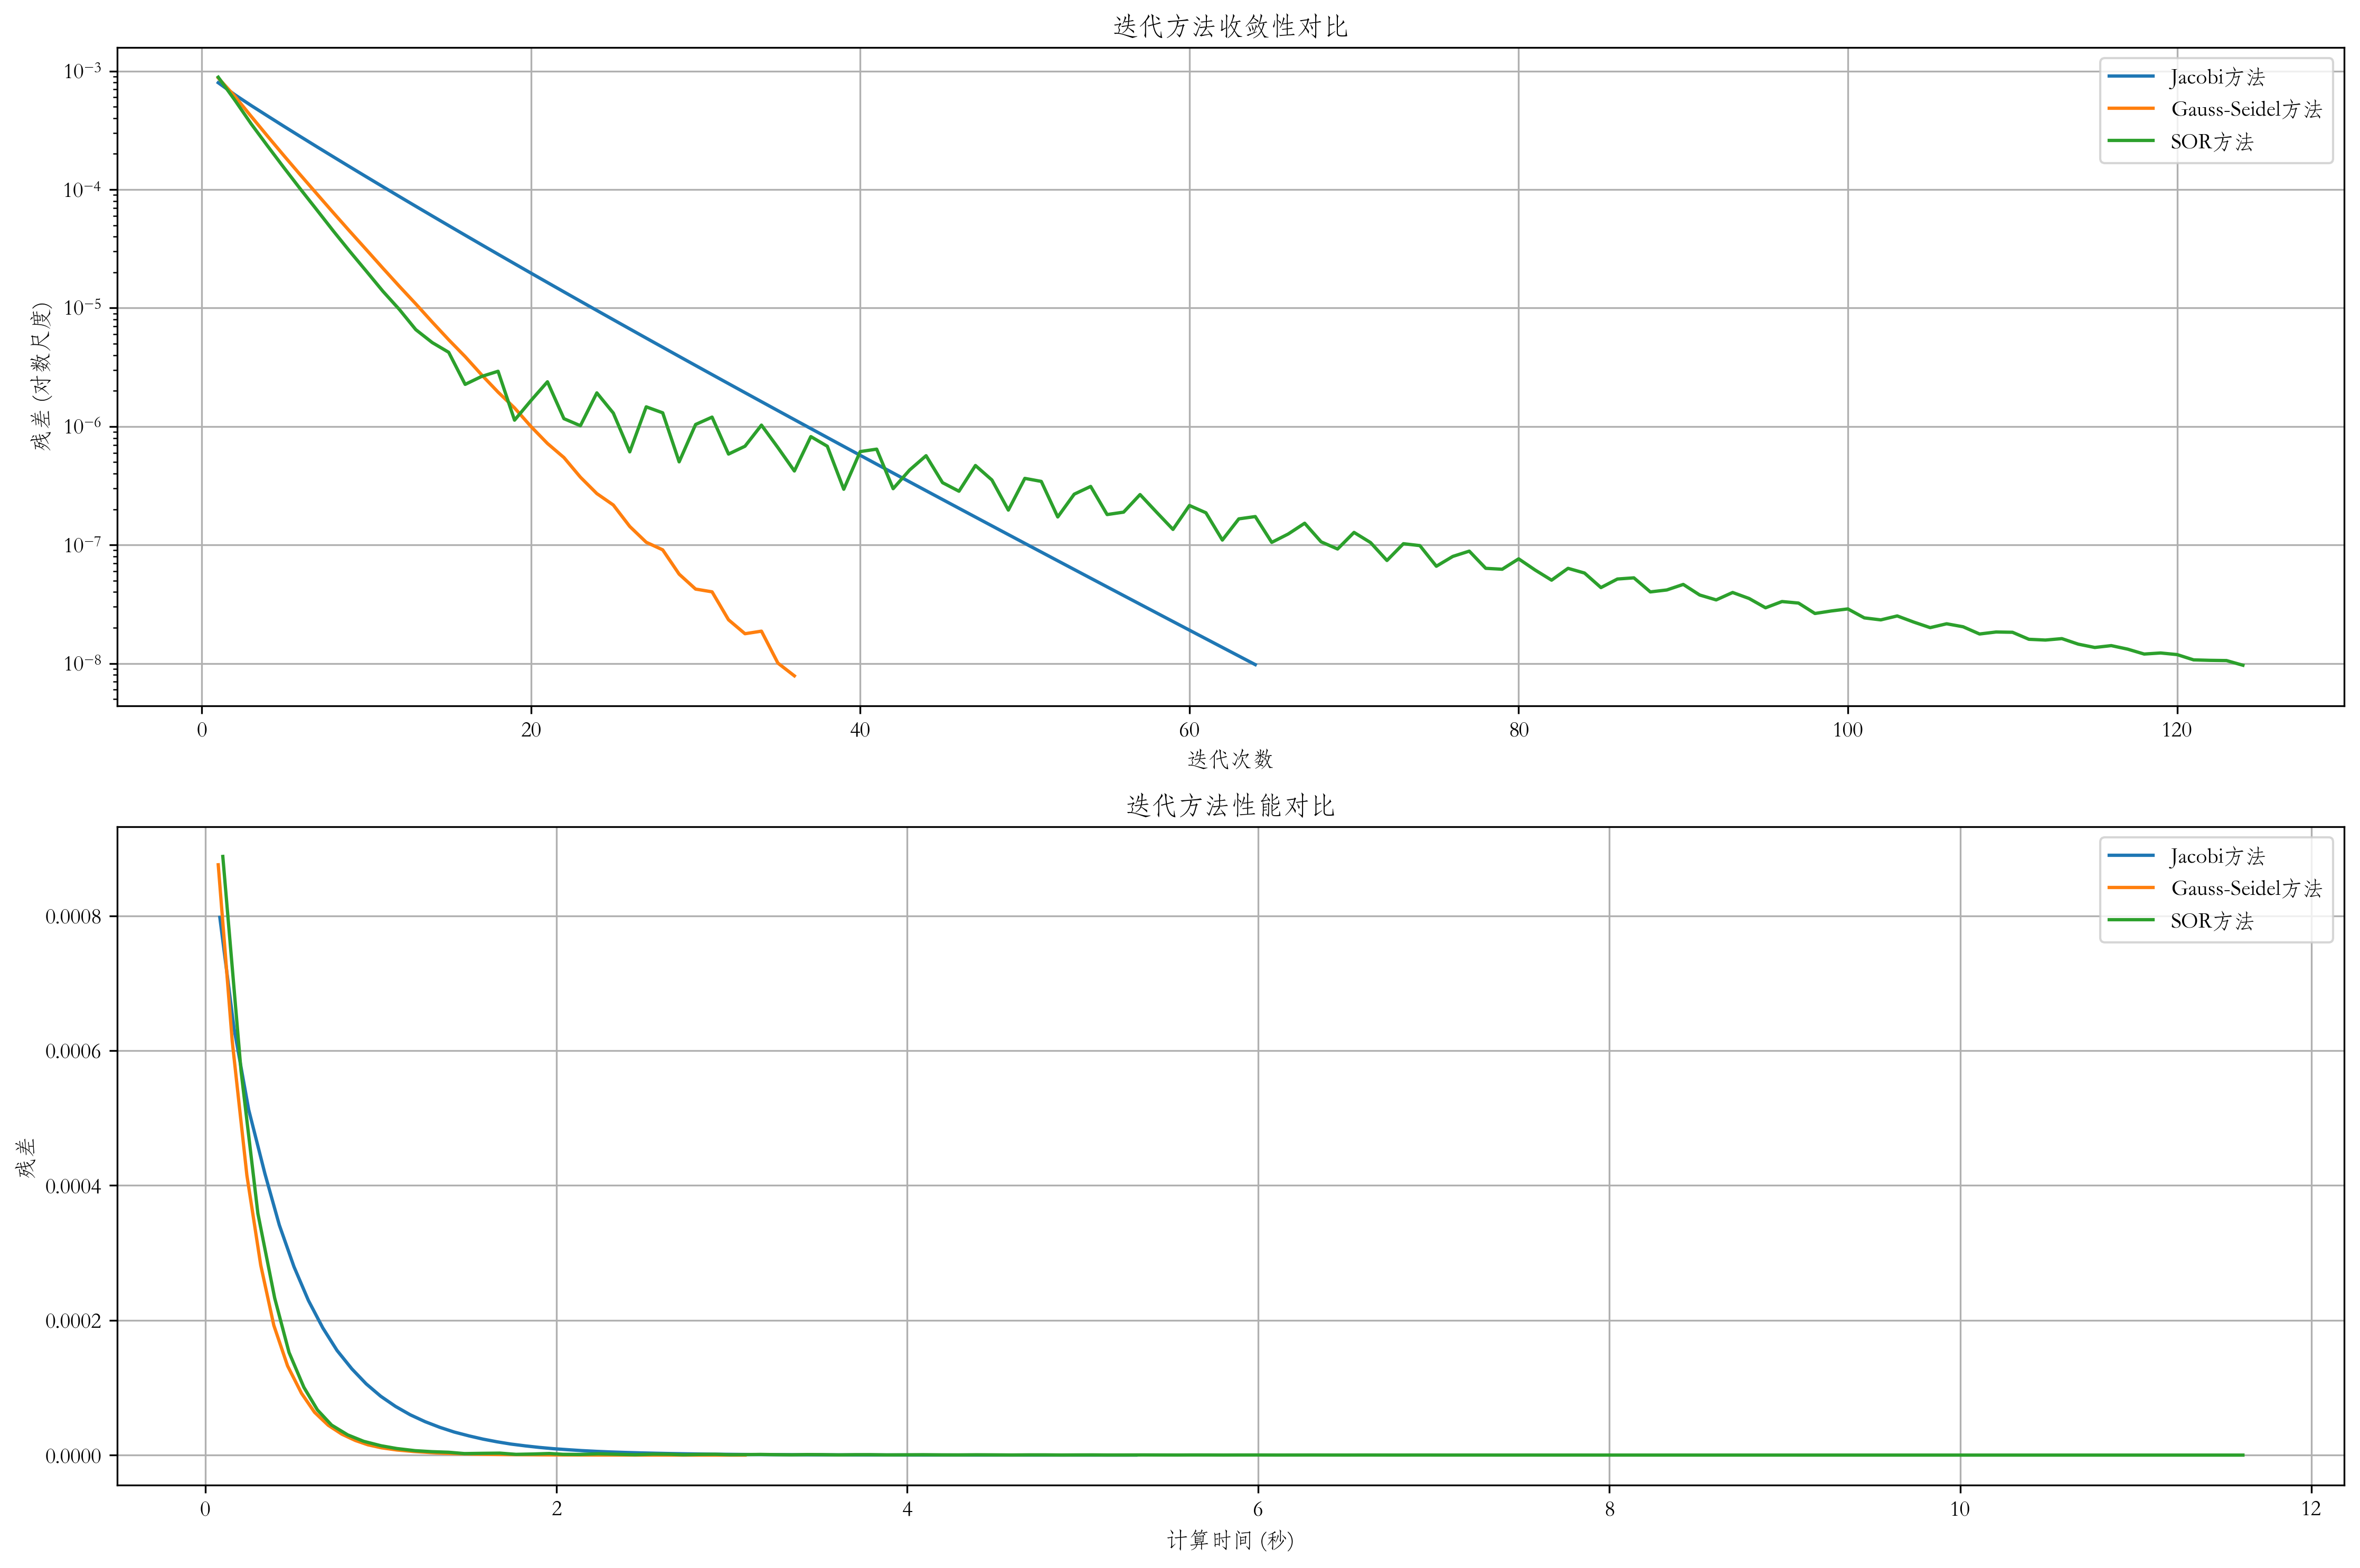


Jacobi方法:
  迭代次数: 64
  计算时间: 5.3027 秒
  最终残差: 9.7653e-09

Gauss-Seidel方法:
  迭代次数: 36
  计算时间: 3.0760 秒
  最终残差: 7.8500e-09

SOR方法:
  迭代次数: 124
  计算时间: 11.6110 秒
  最终残差: 9.6462e-09

处理矩阵: Stanford网页
矩阵维度: (281903, 281903)


SOR方法计算中:  15%|█▌        | 152/1000 [00:03<00:20, 41.85it/s]


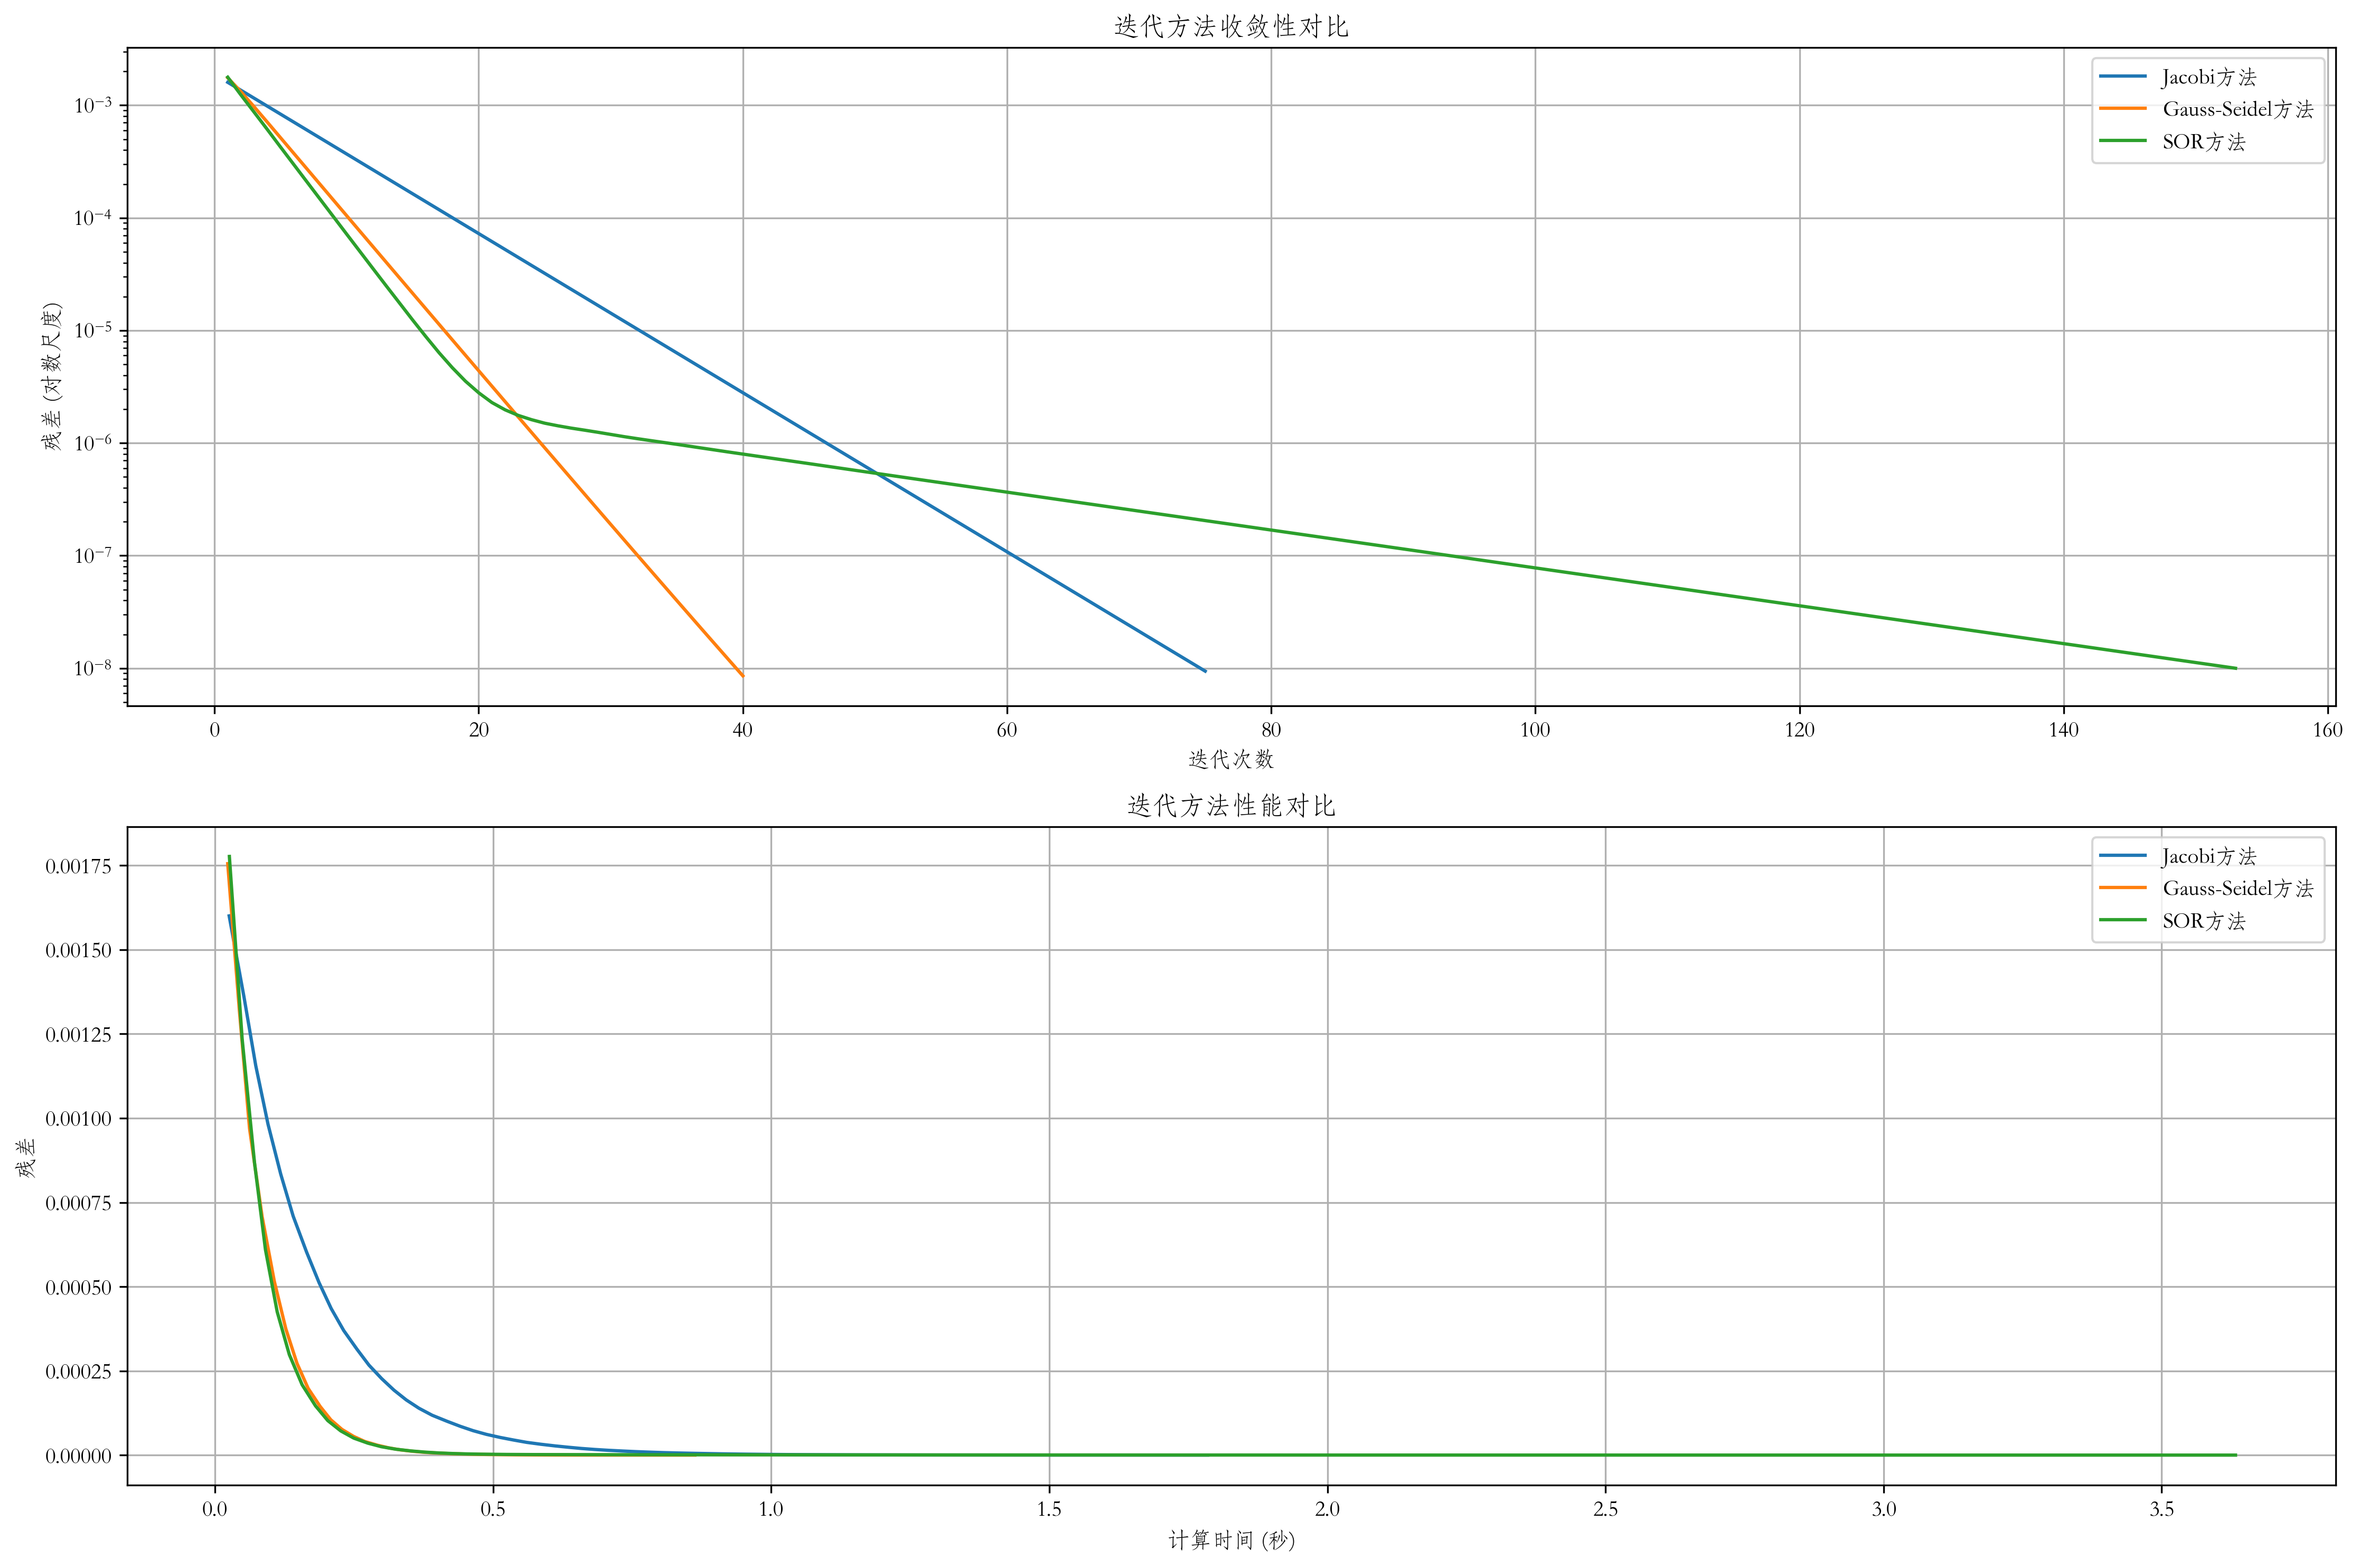


Jacobi方法:
  迭代次数: 75
  计算时间: 1.7847 秒
  最终残差: 9.4220e-09

Gauss-Seidel方法:
  迭代次数: 40
  计算时间: 0.8629 秒
  最终残差: 8.5585e-09

SOR方法:
  迭代次数: 153
  计算时间: 3.6326 秒
  最终残差: 9.9966e-09


In [21]:
import numpy as np
import time
from pyamg.relaxation.relaxation import jacobi, gauss_seidel, sor
from scipy.io import mmread
from scipy.sparse import eye, diags
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.sans-serif'] = ['STFangsong']  # 图中显示中文
plt.rcParams['axes.unicode_minus'] = False  # 图中正常显示负号

def read_mtx_file(file_path):
    sparse_matrix = mmread(file_path)
    row_sums = sparse_matrix.sum(axis=1).A.flatten()
    row_sums[row_sums == 0] = 1
    row_diag = diags(1.0 / row_sums)
    return row_diag @ sparse_matrix

class IterativeSolver:
    def __init__(self, M, b, x0, tol=1e-8, max_iter=1000):
        self.M = M
        self.b = b
        self.x0 = x0.copy()
        self.tol = tol
        self.max_iter = max_iter
        self.residuals = []
        self.times = []
        self.iterations = []
        
    def solve(self, method, method_name, **kwargs):
        x = self.x0.copy()
        start_time = time.time()
        
        for i in tqdm(range(self.max_iter), desc=f"{method_name}计算中"):
            method(self.M, x, self.b, **kwargs)
            residual = np.linalg.norm(self.M @ x - self.b)
            self.residuals.append(residual)
            self.times.append(time.time() - start_time)
            self.iterations.append(i + 1)
            
            if residual < self.tol:
                break
                
        return {
            "迭代次数": i + 1,
            "计算时间": time.time() - start_time,
            "最终残差": residual,
            "解": x
        }

def plot_convergence(solvers, names):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    for solver, name in zip(solvers, names):
        plt.semilogy(solver.iterations, solver.residuals, label=name)
    plt.grid(True)
    plt.xlabel('迭代次数')
    plt.ylabel('残差 (对数尺度)')
    plt.title('迭代方法收敛性对比')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    for solver, name in zip(solvers, names):
        plt.plot(solver.times, solver.residuals, label=name)
    plt.grid(True)
    plt.xlabel('计算时间 (秒)')
    plt.ylabel('残差')
    plt.title('迭代方法性能对比')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 主程序
matrix_files = {
    'Wiki投票': 'wiki-Vote.mtx',
    'Google网页': 'web-Google.mtx',
    'Stanford网页': 'web-Stanford.mtx'
}

for name, file_name in matrix_files.items():
    print(f"\n处理矩阵: {name}")
    A = read_mtx_file(file_name)
    print(f"矩阵维度: {A.shape}")

    alpha = 0.85
    n = A.shape[0]
    I = eye(n, format='csr')
    b = np.ones(n) / n
    M = I - alpha * A

    x0 = np.zeros(n)
    tol = 1e-8
    max_iter = 1000

    solvers = []
    solver_names = []

    jacobi_solver = IterativeSolver(M, b, x0, tol=tol, max_iter=max_iter)
    jacobi_result = jacobi_solver.solve(jacobi, "Jacobi方法")
    solvers.append(jacobi_solver)
    solver_names.append("Jacobi方法")

    gs_solver = IterativeSolver(M, b, x0, tol=tol, max_iter=max_iter)
    gs_result = gs_solver.solve(gauss_seidel, "Gauss-Seidel方法", sweep='forward')
    solvers.append(gs_solver)
    solver_names.append("Gauss-Seidel方法")

    sor_solver = IterativeSolver(M, b, x0, tol=tol, max_iter=max_iter)
    sor_result = sor_solver.solve(sor, "SOR方法", omega=1.1, sweep='forward')
    solvers.append(sor_solver)
    solver_names.append("SOR方法")

    plot_convergence(solvers, solver_names)

    for solver, name in zip(solvers, solver_names):
        print(f"\n{name}:")
        print(f"  迭代次数: {len(solver.iterations)}")
        print(f"  计算时间: {solver.times[-1]:.4f} 秒")
        print(f"  最终残差: {solver.residuals[-1]:.4e}")